In [6]:
from sqlalchemy import create_engine
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

def create_connection():

    load_dotenv()
    host = os.environ.get('DB_DESTINATION_HOST')
    port = os.environ.get('DB_DESTINATION_PORT')
    db = os.environ.get('DB_DESTINATION_NAME')
    username = os.environ.get('DB_DESTINATION_USER')
    password = os.environ.get('DB_DESTINATION_PASSWORD')

    conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}')
    return conn

# установите соединение с базой
conn = create_connection()


In [7]:
flats_orig = pd.read_sql('''
select f.flat_id,f.floor,f.apartment,f.kitchen_area,f.living_area,f.rooms,
f.studio,f.total_area,f.price,f.build_id,
f.build_year,f.build_type,f.latitude,f.longitude,
f.ceiling_height,f.flats_count,f.floors_total,f.has_elevator
from flats_churn as f
''', conn)
flats_orig

,flat_id,floor,apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_id,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,9,False,9.90,19.900000,1,False,35.099998,9500000,6220,1965,6,55.717113,37.781120,2.64,84,12,True
1,1,7,False,0.00,16.600000,1,False,43.000000,13500000,18012,2001,2,55.794849,37.608013,3.00,97,10,True
2,2,9,False,9.00,32.000000,2,False,56.000000,13500000,17821,2000,4,55.740040,37.761742,2.70,80,10,True
3,3,1,False,10.10,43.099998,3,False,76.000000,20000000,18579,2002,4,55.672016,37.570877,2.64,771,17,True
4,4,3,False,3.00,14.000000,1,False,24.000000,5200000,9293,1971,1,55.808807,37.707306,2.60,208,9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141357,141357,16,False,11.00,18.000000,1,False,42.000000,10500000,22455,2013,4,55.626579,37.313503,2.64,672,25,True
141358,141358,5,False,5.28,28.330000,2,False,41.110001,7400000,3162,1960,1,55.727470,37.768677,2.48,80,5,False
141359,141359,7,False,5.30,20.000000,1,False,31.500000,9700000,6513,1966,4,55.704315,37.506584,2.64,72,9,True
141360,141360,15,False,13.80,33.700001,2,False,65.300003,11750000,23952,2017,4,55.699863,37.939564,2.70,480,25,True


In [12]:
flats_orig.describe()

,flat_id,floor,kitchen_area,living_area,rooms,total_area,price,build_id,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total
count,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000,1.413620e+05,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000,141362.000000
mean,70680.500000,7.467346,9.001579,31.056948,2.129476,62.374644,1.944162e+07,14053.665235,1986.600048,3.232941,55.730059,37.589235,2.753650,251.993230,14.107554
std,40807.838714,5.717144,5.264076,23.968640,0.994340,40.295864,6.626954e+07,6988.831066,22.136409,1.459461,0.102611,0.150122,0.223275,207.336169,6.898045
min,0.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01,1.000000,1901.000000,0.000000,55.211460,36.864372,2.000000,1.000000,1.000000
25%,35340.250000,3.000000,6.100000,19.000000,1.000000,39.299999,8.900000e+06,8535.250000,1969.000000,2.000000,55.653858,37.491764,2.640000,111.000000,9.000000
50%,70680.500000,6.000000,8.800000,29.400000,2.000000,53.000000,1.185000e+07,14332.000000,1985.000000,4.000000,55.724686,37.581146,2.640000,200.000000,14.000000
75%,106020.750000,10.000000,10.200000,41.400002,3.000000,72.000000,1.695000e+07,20475.000000,2007.000000,4.000000,55.807323,37.691055,2.800000,324.000000,17.000000
max,141361.000000,56.000000,203.000000,700.000000,20.000000,960.299988,9.873738e+09,24620.000000,2023.000000,6.000000,56.011032,37.946411,27.000000,4455.000000,99.000000


In [60]:
data=flats_orig.copy()
data

,flat_id,floor,apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_id,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,9,False,9.90,19.900000,1,False,35.099998,9500000,6220,1965,6,55.717113,37.781120,2.64,84,12,True
1,1,7,False,0.00,16.600000,1,False,43.000000,13500000,18012,2001,2,55.794849,37.608013,3.00,97,10,True
2,2,9,False,9.00,32.000000,2,False,56.000000,13500000,17821,2000,4,55.740040,37.761742,2.70,80,10,True
3,3,1,False,10.10,43.099998,3,False,76.000000,20000000,18579,2002,4,55.672016,37.570877,2.64,771,17,True
4,4,3,False,3.00,14.000000,1,False,24.000000,5200000,9293,1971,1,55.808807,37.707306,2.60,208,9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141357,141357,16,False,11.00,18.000000,1,False,42.000000,10500000,22455,2013,4,55.626579,37.313503,2.64,672,25,True
141358,141358,5,False,5.28,28.330000,2,False,41.110001,7400000,3162,1960,1,55.727470,37.768677,2.48,80,5,False
141359,141359,7,False,5.30,20.000000,1,False,31.500000,9700000,6513,1966,4,55.704315,37.506584,2.64,72,9,True
141360,141360,15,False,13.80,33.700001,2,False,65.300003,11750000,23952,2017,4,55.699863,37.939564,2.70,480,25,True


In [61]:
def transform(data: pd.DataFrame):
    def bool_to_int(data: pd.DataFrame):
        data[data.select_dtypes(include='bool').columns] = data.select_dtypes(include='bool').astype(int)
        return data

    def remove_duplicates(data: pd.DataFrame):
        feature_cols = data.columns.tolist()
        is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
        data = pd.DataFrame(data[~is_duplicated_features].reset_index(drop=True))
        return data

    def remove_low_price_rows(data: pd.DataFrame):
        '''Удаляем квартиры с явно неверной ценой менее 99999'''
        data = pd.DataFrame(data[data["price"] > 99999])
        return data

    def remove_high_price_rows(data: pd.DataFrame) -> pd.DataFrame:
        '''Удаляем квартиры с ценой более 1'000'000'000'''
        data = pd.DataFrame(data[data["price"] < 1000000000])
        return data

    def remove_outliers_iqr(data: pd.DataFrame):
        filtered_df = data.copy()
        num_cols = data.select_dtypes(["float", "int"]).columns
        threshold = 1.5
        for column in num_cols:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            filtered_df = pd.DataFrame(
                filtered_df[
                    (filtered_df[column] >= lower_bound)
                    & (filtered_df[column] <= upper_bound)
                ]
            )

        return filtered_df

    data = data.drop(columns=['flat_id','build_id'])
    data = remove_duplicates(data)
    data = remove_low_price_rows(data)
    # data = remove_high_price_rows(data)
    data = remove_outliers_iqr(data)
    data = bool_to_int(data)
    return data

data=transform(data)
data

,floor,apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,9,0,9.90,19.900000,1,0,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,1
1,7,0,0.00,16.600000,1,0,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,1
2,9,0,9.00,32.000000,2,0,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,1
4,3,0,3.00,14.000000,1,0,24.000000,5200000,1971,1,55.808807,37.707306,2.60,208,9,1
5,9,0,0.00,0.000000,2,0,51.009998,8490104,2017,4,55.724728,37.743069,2.70,192,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123931,8,0,6.00,42.000000,3,0,64.000000,10800000,1971,4,55.740402,37.834579,2.64,428,9,1
123933,5,0,5.28,28.330000,2,0,41.110001,7400000,1960,1,55.727470,37.768677,2.48,80,5,0
123934,7,0,5.30,20.000000,1,0,31.500000,9700000,1966,4,55.704315,37.506584,2.64,72,9,1
123935,15,0,13.80,33.700001,2,0,65.300003,11750000,2017,4,55.699863,37.939564,2.70,480,25,1


In [62]:
data.describe()

,floor,apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
count,97049.000000,97049.000000,97049.000000,97049.000000,97049.000000,97049.0,97049.000000,9.704900e+04,97049.00000,97049.000000,97049.000000,97049.000000,97049.000000,97049.000000,97049.000000,97049.000000
mean,6.724242,0.005214,8.084577,27.537284,1.943328,0.0,51.477138,1.178479e+07,1984.05558,3.527136,55.728476,37.604175,2.686732,222.440880,13.000309,0.892755
std,4.502143,0.072019,2.984153,14.325348,0.813498,0.0,16.104242,4.449726e+06,19.31967,1.416502,0.103439,0.148832,0.130431,133.333216,5.114020,0.309426
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,11.000000,2.500000e+05,1914.00000,0.000000,55.427238,37.190639,2.450000,1.000000,1.000000,0.000000
25%,3.000000,0.000000,6.000000,19.000000,1.000000,0.0,38.300000,8.500000e+06,1969.00000,4.000000,55.648907,37.495975,2.640000,111.000000,9.000000,1.000000
50%,6.000000,0.000000,8.400000,28.400000,2.000000,0.0,48.000000,1.080000e+07,1979.00000,4.000000,55.717884,37.591702,2.640000,192.000000,12.000000,1.000000
75%,9.000000,0.000000,10.000000,36.000000,3.000000,0.0,60.299999,1.400000e+07,2002.00000,4.000000,55.814205,37.722549,2.700000,298.000000,17.000000,1.000000
max,20.000000,1.000000,16.300000,74.000000,5.000000,0.0,118.500000,2.840000e+07,2023.00000,6.000000,56.011032,37.946411,3.000000,638.000000,29.000000,1.000000


In [71]:
list(data.columns)

['floor',
 'apartment',
 'kitchen_area',
 'living_area',
 'rooms',
 'studio',
 'total_area',
 'price',
 'build_year',
 'build_type',
 'latitude',
 'longitude',
 'ceiling_height',
 'flats_count',
 'floors_total',
 'has_elevator']

count    97049.000000
mean       222.440880
std        133.333216
min          1.000000
25%        111.000000
50%        192.000000
75%        298.000000
max        638.000000
Name: flats_count, dtype: float64

<Axes: xlabel='flats_count', ylabel='Count'>

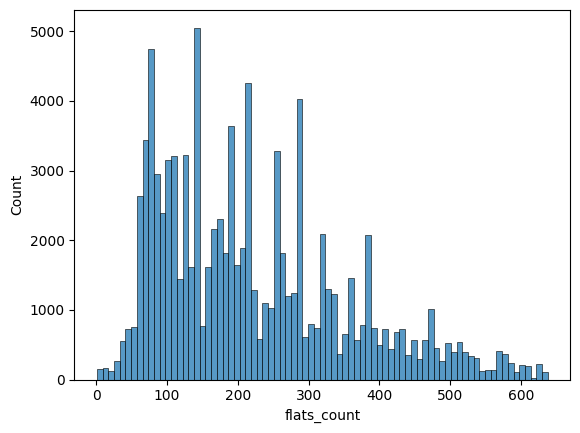

In [77]:
import seaborn as sns

check='flats_count'
'''Ищем минимум убирающий аномальный выброс'''
# data = pd.DataFrame(data[data["price"] > 99999])


display(data[check].describe())
display(sns.histplot(data[check]))

In [79]:
clean_flats_orig = pd.read_sql('''
select *
from clean_flats_churn as f
''', conn)
clean_flats_orig

,id,floor,apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,build_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,1,9,0,9.9,19.900000,1,0,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,1
1,2,7,0,0.0,16.600000,1,0,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,1
2,3,9,0,9.0,32.000000,2,0,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,1
3,4,3,0,3.0,14.000000,1,0,24.000000,5200000,1971,1,55.808807,37.707306,2.60,208,9,1
4,5,9,0,0.0,0.000000,2,0,51.009998,8490104,2017,4,55.724728,37.743069,2.70,192,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,21996,9,0,9.2,28.900000,2,0,45.900002,11500000,1975,6,55.669018,37.586014,2.48,168,12,1
21996,21997,15,0,9.0,33.000000,2,0,51.000000,9500000,1989,4,55.609989,37.698009,2.64,191,17,1
21997,21998,3,0,6.2,29.799999,2,0,47.000000,7400000,1977,4,55.610119,37.739349,2.64,72,9,1
21998,21999,6,0,6.0,27.500000,2,0,46.000000,7900000,1968,4,55.622498,37.652489,2.64,357,9,1


In [81]:
clean_flats_orig.dtypes

id                  int64
floor               int64
apartment           int64
kitchen_area      float64
living_area       float64
rooms               int64
studio              int64
total_area        float64
price               int64
build_year          int64
build_type          int64
latitude          float64
longitude         float64
ceiling_height    float64
flats_count         int64
floors_total        int64
has_elevator        int64
dtype: object

In [99]:
data=clean_flats_orig.copy()

In [100]:
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

target = data['price']
data = data.drop(['id','price'], axis=1)

# Разделение данных на числовые и категориальные признаки
cat_features = data.select_dtypes(include='int64')
potential_binary_features = cat_features.nunique() == 2
binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = data.select_dtypes(['float64'])

# Предобработка данных
preprocessor = ColumnTransformer(
    [
        # ('binary', OneHotEncoder(drop=params['one_hot_drop']), binary_cat_features.columns.tolist()),
        ('cat', CatBoostEncoder(), other_cat_features.columns.tolist()),
        ('num', StandardScaler(), num_features.columns.tolist())
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


In [101]:
binary_cat_features

,apartment,has_elevator
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
21995,0,1
21996,0,1
21997,0,1
21998,0,1


In [102]:
other_cat_features

,floor,rooms,studio,build_year,build_type,flats_count,floors_total
0,9,1,0,1965,6,84,12
1,7,1,0,2001,2,97,10
2,9,2,0,2000,4,80,10
3,3,1,0,1971,1,208,9
4,9,2,0,2017,4,192,17
...,...,...,...,...,...,...,...
21995,9,2,0,1975,6,168,12
21996,15,2,0,1989,4,191,17
21997,3,2,0,1977,4,72,9
21998,6,2,0,1968,4,357,9


In [103]:
num_features

,kitchen_area,living_area,total_area,latitude,longitude,ceiling_height
0,9.9,19.900000,35.099998,55.717113,37.781120,2.64
1,0.0,16.600000,43.000000,55.794849,37.608013,3.00
2,9.0,32.000000,56.000000,55.740040,37.761742,2.70
3,3.0,14.000000,24.000000,55.808807,37.707306,2.60
4,0.0,0.000000,51.009998,55.724728,37.743069,2.70
...,...,...,...,...,...,...
21995,9.2,28.900000,45.900002,55.669018,37.586014,2.48
21996,9.0,33.000000,51.000000,55.609989,37.698009,2.64
21997,6.2,29.799999,47.000000,55.610119,37.739349,2.64
21998,6.0,27.500000,46.000000,55.622498,37.652489,2.64


In [104]:
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE')

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(data, target)


Learning rate set to 0.066724
0:	learn: 4145631.5792923	total: 7.98ms	remaining: 7.97s
1:	learn: 4004582.3211214	total: 14.9ms	remaining: 7.46s
2:	learn: 3871138.4738271	total: 23.6ms	remaining: 7.85s
3:	learn: 3742469.0299361	total: 29.9ms	remaining: 7.43s
4:	learn: 3631443.8453193	total: 38ms	remaining: 7.56s
5:	learn: 3535050.0605420	total: 47.5ms	remaining: 7.87s
6:	learn: 3454332.1513566	total: 54.3ms	remaining: 7.7s
7:	learn: 3364740.9479546	total: 60.1ms	remaining: 7.46s
8:	learn: 3282739.3313258	total: 65.6ms	remaining: 7.22s
9:	learn: 3218825.2319864	total: 70.9ms	remaining: 7.01s
10:	learn: 3158493.5731126	total: 75.5ms	remaining: 6.78s
11:	learn: 3103433.7572652	total: 81.4ms	remaining: 6.71s
12:	learn: 3044089.8518880	total: 87.8ms	remaining: 6.66s
13:	learn: 2998826.1930701	total: 93.4ms	remaining: 6.58s
14:	learn: 2951812.1805642	total: 99.5ms	remaining: 6.53s
15:	learn: 2913705.0581260	total: 106ms	remaining: 6.53s
16:	learn: 2882902.1707286	total: 113ms	remaining: 6.55s

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', CatBoostEncoder(),
                                                  ['floor', 'rooms', 'studio',
                                                   'build_year', 'build_type',
                                                   'flats_count',
                                                   'floors_total']),
                                                 ('num', StandardScaler(),
                                                  ['kitchen_area',
                                                   'living_area', 'total_area',
                                                   'latitude', 'longitude',
                                                   'ceiling_height'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x79bbb197b880>)])